# Antithetic Integral Feedback with Michaelis-Menten Actuation

In this report we want to investigate the behaviour of antithetic integral feedback system with the following close-loop ODE using simulation and critical analysis:

<center>$\dot{x}_1 = \theta_1 \frac{z_1}{\rho + z_1} - \gamma _p x_1$</center>

<center>$\dot{x}_2 = k x_1 - \gamma _p x_2 + \omega$</center>

<center>$\dot{z}_1 = \mu - \eta z_1 z_2$</center>

<center>$\dot{z}_2 = \theta_2 x_2 - \eta z_1 z_2$</center>

The simulation is written in this Python object called `Antithetic`

In [1]:
from antithetic import Antithetic
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%load_ext autoreload

1) Initialise the parameters as the assignment sheet instructed. To find a reasonable initial condition to run the simulation, we attempt to solve for the equilibrium $\dot{x}_1=\dot{x}_2=\dot{z}_1=\dot{z}_2=0$. This gives the following results: 

<center>$x_2^* = \frac{\mu}{\theta_2}$, $x_1^* = \frac{\gamma_p \mu / \theta_2 - \omega}{k}$, $z_1^* = \frac{\gamma_p x_1^* \rho}{\theta_1 - \gamma_p x_1^*} = \frac{\rho \gamma_p^2\mu - \rho \gamma_p \omega \theta_2}{k \theta_1 \theta_2 - \gamma_p^2\mu + \gamma_p \omega \theta_2}$, $z_2^* = \frac{\mu}{\eta z_1^*} = \frac{\mu}{\eta} \frac{k \theta_1 \theta_2 - \gamma_p^2\mu + \gamma_p \omega \theta_2}{\rho \gamma_p^2\mu - \rho \gamma_p \omega \theta_2}$</center>

In [2]:
param = {'omega': 0, 'rho': 1, 'theta1': 1, 'theta2': 1, 
         'k': 1, 'degrade_p': 1, 'mu': 100, 'eta': 100}
sim1 = Antithetic(**param)

Substituting the values gives infeasible solution because concentration cannot be negative: $x_2 = x_1 = 100$, $z_1 = 1/z_2 = -100/99$, therefore we just arbitrarily insert some initial condition to examine the simulation.

In [3]:
initial_cond = [100, 200, 10, 10]  #[x1, x2, z1, z2]
timeseries = sim1.get_response(initial_cond, length=10, methods='RK45')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.33‰/s]


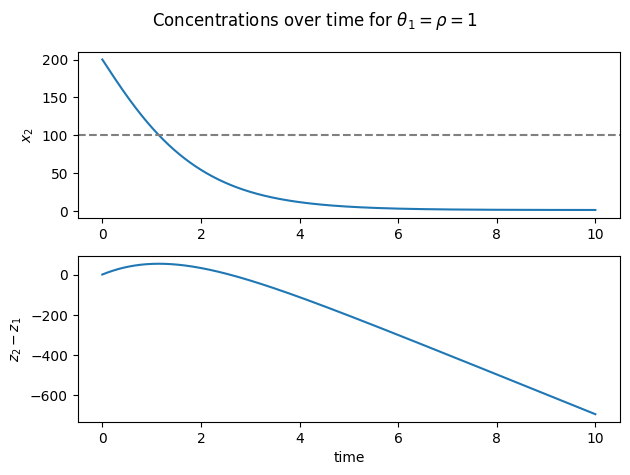

In [4]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(timeseries.t, timeseries.y[1])
axes[0].axhline(y=100, color="0.5", linestyle="--")
axes[0].set_ylabel("$x_2$")
axes[1].plot(timeseries.t, timeseries.y[3]-timeseries.y[2])
axes[1].set_ylabel("$z_2-z_1$")
fig.suptitle(r"Concentrations over time for $\theta_1=\rho=1$")
plt.xlabel("time")
fig.tight_layout()
plt.show()

The concentration of $x_2$ passed the desired steady state, $\mu/\theta_2 = 100$, and decreased all the way to almost 0.
This makes the negative time integral of error (state of $x_2$ - desired state) kept decreasing, which can be read from $z_2 - z_1$. However this is not helpful because the activation from $z_1$ is still very small, despite the fact that $z_1$ is increasing linearly because of the constant brith rate. The system is not in steady state.

So, to see what causes this behaviour, all four concentrations were plotted. The first significant event is the fast annihilation between $z_2$ and $z_1$ because of large $\eta$. But for $z_2$ this annihilation is not faster than the activation from high concentration $x_2$ until $x_2$'s concentration reached 100. Then, $z_2$ started to decrease agian. Regardless, the concentration of $z_1$ remains 0 during this period meaning there is not enough activation for $x_1$ and hence $x_2$. Although it starts to increase after $z_2$ reached 0 concentration. $\theta_1$ is too small to bring $x_1$ back to a high steady state because of this nonlinear mapping (can only be close to one even if $z_1$ is really large).

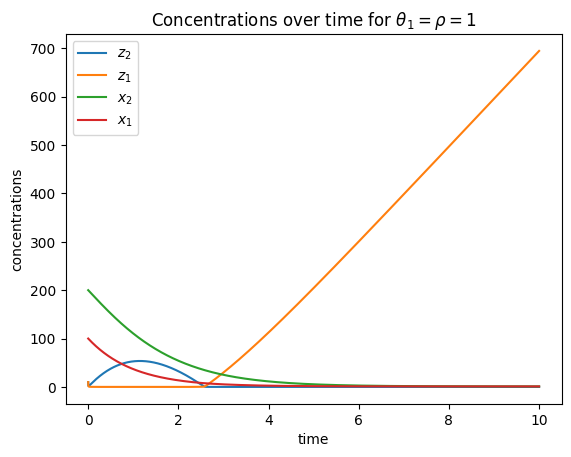

1.0472189468636484


In [5]:
plt.plot(timeseries.t, timeseries.y[3], label="$z_2$")
plt.plot(timeseries.t, timeseries.y[2], label="$z_1$")
plt.plot(timeseries.t, timeseries.y[1], label="$x_2$")
plt.plot(timeseries.t, timeseries.y[0], label="$x_1$")
plt.ylabel("concentrations")
plt.xlabel("time")
plt.legend()
plt.title(r"Concentrations over time for $\theta_1=\rho=1$")
plt.show()
print(timeseries.y[1][-1])

2) Running the simulation at various values of $\theta_1$ gives different interesting behaviour. A range of it gives the desired value of $x_2^* = \mu/\theta_2$ at steady state. By inspection of the plots of $x_2$ and $\Delta z$ the lower bound is given by the existence of equilibrium (especially for $z_1$) and the upper bound is given by stability. The range is found to be $100 < \theta_1 \le 115.3$. Here we changed the initial condition for convenience of investigation.

[ 95. 100. 105. 110. 115. 120.]


6it [01:00, 10.12s/it]


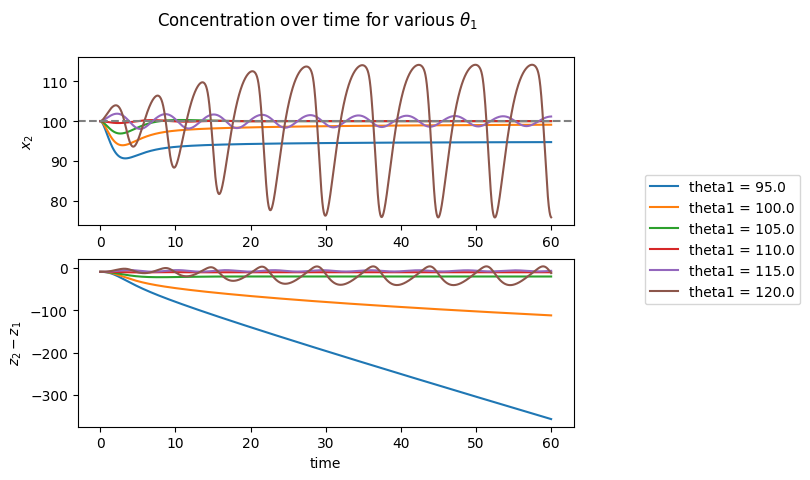

In [6]:
theta1 = np.linspace(95, 120, 6)
initial_cond = [100, 100, 10, 1]
print(theta1)
y_ss = []
fig, axes = plt.subplots(2, 1) 
for series, theta in tqdm(sim1.responses_at_theta1(initial_cond, 60, theta1)):
    axes[0].plot(series.t, series.y[1], label="theta1 = {}".format(theta))
    axes[1].plot(series.t, series.y[3] - series.y[2])
    y_ss.append(series.y[1][-1])
axes[0].axhline(y=100, color="0.5", linestyle="--")
axes[0].set_ylabel("$x_2$")
axes[1].set_ylabel("$z_2-z_1$")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle(r"Concentration over time for various $\theta_1$")
plt.xlabel("time")
plt.show()

For the behaviour within the range (100, 115.3], the steady state value of $x_2$ converges to 100 and the integrator value $z_1 - z_2$ saturates to a fixed value meaning that the steady state error of $x_2$ has been reduce to zero. And for the behaviour outside this range, two examples are shown below:

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:25<00:00,  4.87‰/s]


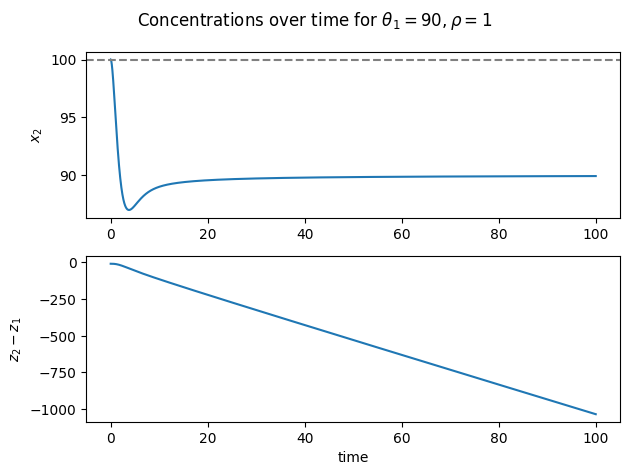

In [7]:
param = {'omega': 0, 'rho': 1, 'theta1': 90, 'theta2': 1, 
         'k': 1, 'degrade_p': 1, 'mu': 100, 'eta': 100}
sim_noss = Antithetic(**param)
noss = sim_noss.get_response([100, 100, 10, 1], 100)
fig, axes = plt.subplots(2, 1)
axes[0].plot(noss.t, noss.y[1])
axes[0].axhline(y=100, color="0.5", linestyle="--")
axes[0].set_ylabel("$x_2$")
axes[1].plot(noss.t, noss.y[3]-noss.y[2])
axes[1].set_ylabel("$z_2-z_1$")
fig.suptitle(r"Concentrations over time for $\theta_1=90, \rho=1$")
plt.xlabel("time")
fig.tight_layout()
plt.show()

In the case of $\theta_1 < 100$, the value of $x_2$ converges to 90, which means the integrator keeps integrating the steady state error over time. As a result, the value of $z_1$ keeps increasing linearly in time. So, the system is not generally in steady state or equilibrium.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [00:09<00:00, 101.15‰/s]


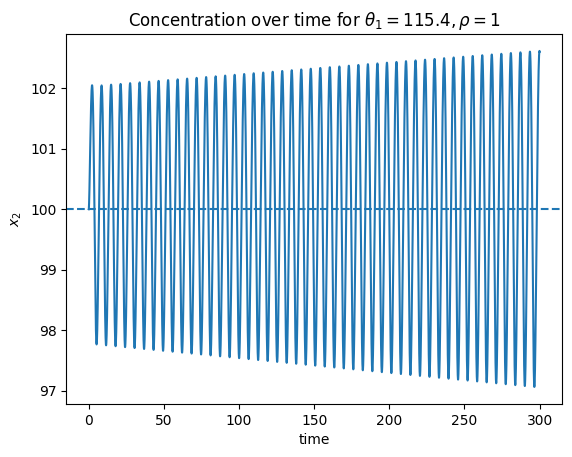

In [8]:
param = {'omega': 0, 'rho': 1, 'theta1': 115.4, 'theta2': 1, 
         'k': 1, 'degrade_p': 1, 'mu': 100, 'eta': 100}
sim_unstable = Antithetic(**param)
unstable = sim_unstable.get_response([100, 100, 10, 1], 300)
plt.plot(unstable.t, unstable.y[1])
plt.axhline(y=100, linestyle="--")
plt.xlabel("time")
plt.ylabel("$x_2$")
plt.title(r"Concentration over time for $\theta_1=115.4, \rho=1$")
plt.show()

In the case of $115.3 < \theta_1$, the system becomes unstable. Therefore, divergence happens in our simulation, although this will still be restricted by the fact that concentration cannot be negative.

3) From what we obtained in part 1, the steady state of the system as a function of $\theta_1$ will be:

<center>$x_2^* = 100$, $x_1^* = 100$, $z_1^* = \frac{100}{\theta_1 - 100}$, $z_2^* = \frac{\theta_1 - 100}{100}$</center>

We can check these result from simulation by setting a long run time.

In [9]:
theta1 = np.linspace(101, 115, 15)
initial_cond = [100, 100, 10, 1]
print(theta1)
y_ss = [[], [], [], []]
for series, theta in tqdm(sim1.responses_at_theta1(initial_cond, 500, theta1)):
    y_ss[0].append(series.y[0][-1])
    y_ss[1].append(series.y[1][-1])
    y_ss[2].append(series.y[2][-1])
    y_ss[3].append(series.y[3][-1])

[101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114.
 115.]


15it [09:32, 38.19s/it]


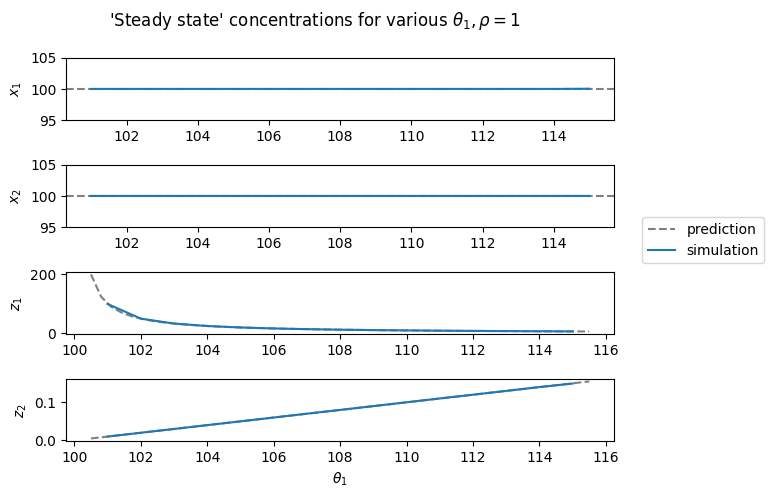

In [10]:
fig, axes = plt.subplots(4, 1)
x_theta = np.linspace(100.5, 115.5, 50)
axes[0].axhline(y=100, color='0.5', linestyle="--", label="prediction")
axes[0].plot(theta1, y_ss[0], label="simulation")
axes[0].set_ylim([95, 105])
axes[0].set_ylabel("$x_1$")
axes[1].axhline(y=100, color='0.5', linestyle="--")
axes[1].plot(theta1, y_ss[1])
axes[1].set_ylim([95, 105])
axes[1].set_ylabel("$x_2$")
axes[2].plot(x_theta, 100/(x_theta - 100), color='0.5', linestyle="--")
axes[2].plot(theta1, y_ss[2])
axes[2].set_ylabel("$z_1$")
axes[3].plot(x_theta, (x_theta - 100)/100, color='0.5', linestyle="--")
axes[3].plot(theta1, y_ss[3])
axes[3].set_ylabel("$z_2$")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle(r"'Steady state' concentrations for various $\theta_1, \rho=1$")
fig.tight_layout()
plt.xlabel(r"$\theta_1$")
plt.show()

Perform linearisation about the equilibrium: $\dot{\delta} = A\delta$

$$A =\begin{bmatrix} -\gamma_p & 0 & \frac{\theta_1\rho}{(\rho + z_1^*)^2} & 0 \\ k & -\gamma_p & 0 & 0 \\ 0 & 0 & -\eta z_2^* & -\eta z_1^* \\ 0 & \theta_2 & -\eta z_2^* & -\eta z_1^* \end{bmatrix}$$

The eigenvalues of this matrix A can be found by $det(sI - A) = 0$
$$det(sI - A) = (\gamma_p + s)^2 [s^2 + (\eta z_1^* + \eta z_2^*)s] + \frac{k\theta_1\theta_2\rho\eta z_1^*}{(\rho + z_1^*)^2} = 0$$

A similar analysis as [1] can be done to this equation. Substitute $s = i \omega^* \gamma_p$ and take the magnitude and phase:

$$X = \gamma_p \omega^* (1 + \omega^{*2}) \sqrt{\phi^2 + \omega^{*2}}$$
$$2 tan^{-1}(\omega^*)+tan^{-1}(\frac{\omega^*}{\phi}) = \frac{\pi}{2} + 2k\pi$$

Where $X = \frac{k\theta_1\theta_2\rho\eta z_1^*}{(\rho + z_1^*)^2 \gamma_p^2}$ and $\phi = \frac{(\eta z_1^* + \mu / z_1^*)}{\gamma_p}$. And by using the Theorem S2 in [1]: $tan^{-1}(\frac{\omega^*}{\phi}) \rightarrow 0$, we get:

$$\omega^* = tan(\frac{\pi}{4} + k\pi) = 1$$

Assuming $\phi^2 >> 1$, and $\eta z_1^* >> \mu / z_1^*$, which are actually validated by our example simulations and previous calculations, we can then obtain:

$$k\theta_1\theta_2\rho\eta \approx \gamma_p 2 \eta (\rho + z_1^*)^2$$

Substitute the values from previous section we get:

$$\theta_1^2 - 202\theta_1 + 10000 = 0$$
$$\theta_1 \approx 115.2 \text{ or } 86.8$$

These are the value calculated to be the boundary for stability, which actually matched approximately with our measurement. And to prove stability within our specified range, we will plot all the eigenvalues from our linearisation matrix for $\theta_1$ within this range. 

50it [00:00, 209.64it/s]


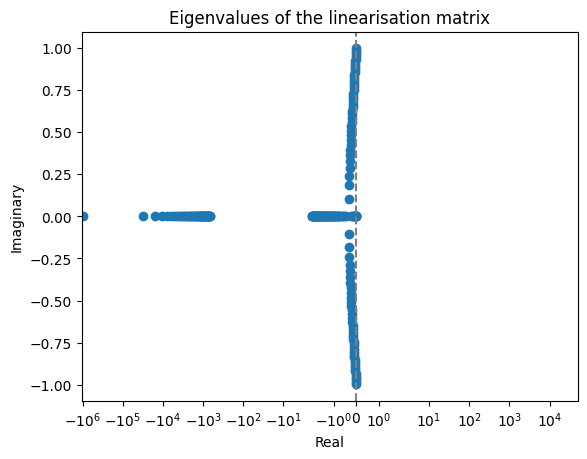

Is there any positive real part? False


In [11]:
theta1 = np.linspace(100.01, 115.3, 50)
real = []
imaginary = []
for w in tqdm(sim1.linearisation(theta1)):
    for v in w:
        real.append(v.real)
        imaginary.append(v.imag)
plt.scatter(real, imaginary)
plt.axvline(x=0, color='0.5', linestyle="--")
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.xscale("symlog")
plt.title(r"Eigenvalues of the linearisation matrix")
plt.show()
print("Is there any positive real part? {}".format(max(real) > 0))

4) Now set $\rho = 10$

In [12]:
param = {'omega': 0, 'rho': 1, 'theta1': 110, 'theta2': 1, 
         'k': 1, 'degrade_p': 1, 'mu': 100, 'eta': 100}
sim2 = Antithetic(**param)
initial_cond = [100, 100, 10, 10]
fast_res = sim2.get_response(initial_cond, length=100, methods='RK45')
sim2.rho = 10
slow_res = sim2.get_response(initial_cond, length=100, methods='RK45')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.39‰/s]


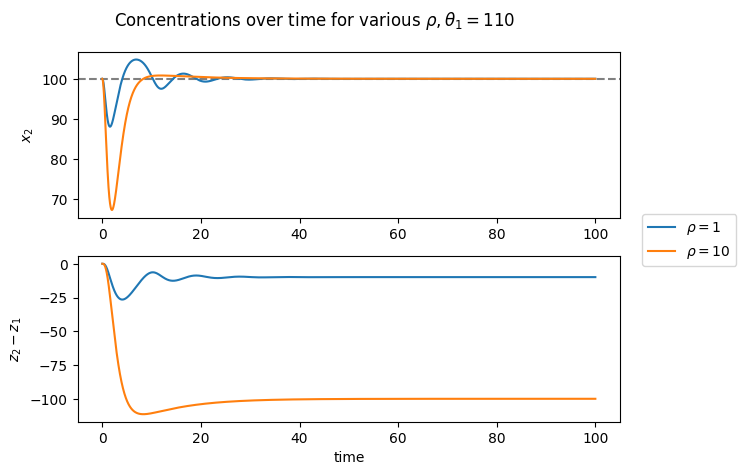

In [13]:
fig, axes = plt.subplots(2, 1)
axes[0].axhline(y=100, color="0.5", linestyle="--")
axes[0].plot(fast_res.t, fast_res.y[1], label=r"$\rho=1$")
axes[0].plot(slow_res.t, slow_res.y[1], label=r"$\rho=10$")
axes[0].set_ylabel("$x_2$")
axes[1].plot(fast_res.t, fast_res.y[3]-fast_res.y[2])
axes[1].plot(slow_res.t, slow_res.y[3]-slow_res.y[2])
axes[1].set_ylabel("$z_2-z_1$")
fig.suptitle(r"Concentrations over time for various $\rho, \theta_1=110$")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("time")
fig.tight_layout()
plt.show()

It seems like this change in $\rho$ reduces the oscillation in the system which can potentially improve stability. It also means a higher steady state $z_1$ to effectively bring $x_2$ to the desired state. This is indicated from our above calculation: $\rho$ exist in our steady state $z_1$ such that a higher $\rho$ increases $z_1^*$ linearly. If we leave $\rho$ out of the subtitution in our linearisation, the calculated stability boundary will then be slightly different. Let us numerically solve this, and run a few simulation to verify our statements.

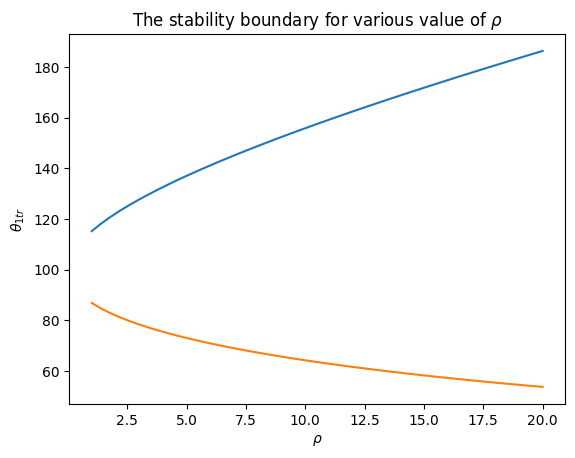

In [14]:
%autoreload
rho = np.linspace(1, 20, 50)
upper_stable = []
lower_stable = []
for r in rho:
    upper_stable.append(sim2.stable_threshold_rho(r, init=101))
    lower_stable.append(sim2.stable_threshold_rho(r, init=99))
plt.plot(rho, upper_stable, label="upper stability threshold")
plt.plot(rho, lower_stable, label="lower stability threshold")
plt.ylabel(r"$\theta_{1tr}$")
plt.xlabel(r"$\rho$")
plt.title(r"The stability boundary for various value of $\rho$")
plt.show()

The stability range for $\theta_1$ is now improved as we expected. For example, if we now run simulation at $\theta_1 = 125$, the system will still converge to steady state.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.04‰/s]


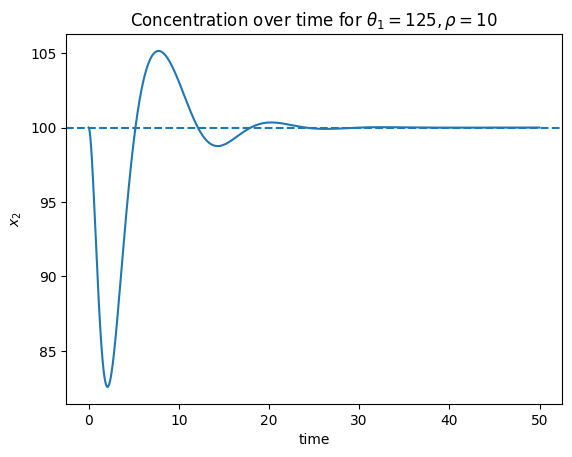

In [15]:
param = {'omega': 0, 'rho': 10, 'theta1': 125, 'theta2': 1, 
         'k': 1, 'degrade_p': 1, 'mu': 100, 'eta': 100}
sim_improv = Antithetic(**param)
better_stable = sim_improv.get_response([100, 100, 10, 1], 50)
plt.plot(better_stable.t, better_stable.y[1])
plt.axhline(y=100, linestyle="--")
plt.xlabel("time")
plt.ylabel(r"$x_2$")
plt.title(r"Concentration over time for $\theta_1=125, \rho=10$")
plt.show()

However it is worth noting that there will be a physical limitation to the maximum concentration of some molecule, hence the value of $\rho$ should still be set carefully although it can improve the stability.

5) Now we examine some perturbation in $\omega$

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.53‰/s]


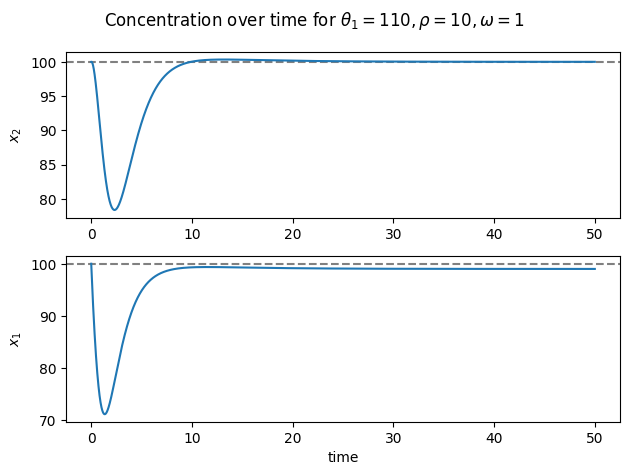

In [16]:
param = {'omega': 1, 'rho': 10, 'theta1': 110, 'theta2': 1, 
         'k': 1, 'degrade_p': 1, 'mu': 100, 'eta': 100}
sim3 = Antithetic(**param)
disturbance = sim3.get_response([100, 100, 10, 1], 50)
fig, axes = plt.subplots(2, 1)
axes[0].axhline(y=100, color="0.5", linestyle="--")
axes[0].plot(disturbance.t, disturbance.y[1])
axes[0].set_ylabel("$x_2$")
axes[1].axhline(y=100, color="0.5", linestyle="--")
axes[1].plot(disturbance.t, disturbance.y[0])
axes[1].set_ylabel("$x_1$")
fig.suptitle(r"Concentration over time for $\theta_1=110, \rho=10, \omega=1$")
plt.xlabel("time")
fig.tight_layout()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.20‰/s]


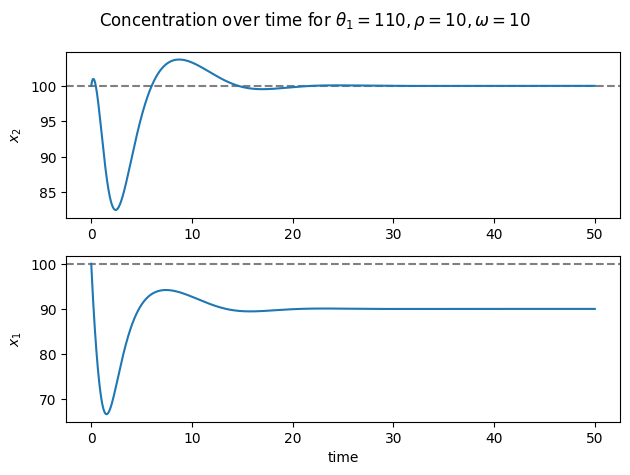

In [17]:
param = {'omega': 10, 'rho': 10, 'theta1': 110, 'theta2': 1, 
         'k': 1, 'degrade_p': 1, 'mu': 100, 'eta': 100}
sim4 = Antithetic(**param)
disturbance = sim4.get_response([100, 100, 10, 1], 50)
fig, axes = plt.subplots(2, 1)
axes[0].axhline(y=100, color="0.5", linestyle="--")
axes[0].plot(disturbance.t, disturbance.y[1])
axes[0].set_ylabel("$x_2$")
axes[1].axhline(y=100, color="0.5", linestyle="--")
axes[1].plot(disturbance.t, disturbance.y[0])
axes[1].set_ylabel("$x_1$")
fig.suptitle(r"Concentration over time for $\theta_1=110, \rho=10, \omega=10$")
plt.xlabel("time")
fig.tight_layout()
plt.show()

By inspection, an increase in $\omega$ causes more oscillation when $\theta_1=110$, what it does to stability is not known very well. So, we look at the linearisation again.

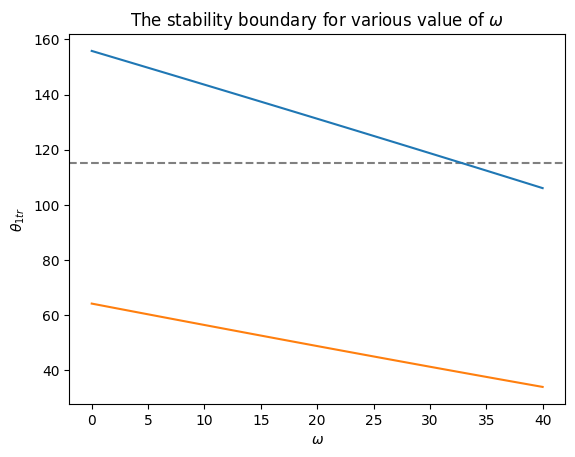

Omega at intersection 32.72727272727273


In [18]:
%autoreload
omega = np.linspace(0, 40, 100)
upper_stable = []
lower_stable = []
for r in omega:
    upper_stable.append(sim2.stable_threshold_omega(r, init=120))
    lower_stable.append(sim2.stable_threshold_omega(r, init=55))
plt.axhline(y=115.3, color="0.5", linestyle="--")
plt.plot(omega, upper_stable, label="upper stability threshold")
plt.plot(omega, lower_stable, label="lower stability threshold")
plt.ylabel(r"$\theta_{1tr}$")
plt.xlabel(r"$\omega$")
plt.title(r"The stability boundary for various value of $\omega$")
plt.show()
print("Omega at intersection {}".format(omega[min(range(len(upper_stable)), 
                key=lambda i: abs(upper_stable[i]-115.3))]))

From this plot we can clearly see that the disturbance shifted the stable region of the system down while slightly decreasing its range. The largest bound $c$ on $\omega$ that the system can tolerate is determined by the upper limit of stability. Here we plotted the line for upper bound $b$ for $\theta_1$. The intersection is at $\omega \approx 32.7$. We validate this result by running some simulation.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.11‰/s]


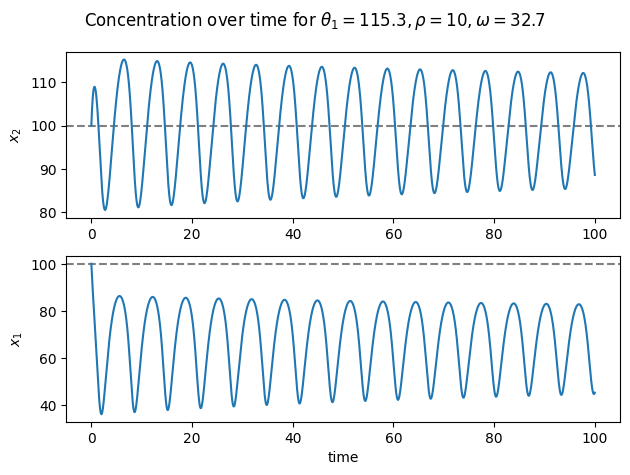

In [19]:
param = {'omega': 32.7, 'rho': 10, 'theta1': 115.3, 'theta2': 1, 
         'k': 1, 'degrade_p': 1, 'mu': 100, 'eta': 100}
sim5 = Antithetic(**param)
oscillation = sim5.get_response([100, 100, 10, 1], 100)
fig, axes = plt.subplots(2, 1)
axes[0].axhline(y=100, color="0.5", linestyle="--")
axes[0].plot(oscillation.t, oscillation.y[1])
axes[0].set_ylabel("$x_2$")
axes[1].axhline(y=100, color="0.5", linestyle="--")
axes[1].plot(oscillation.t, oscillation.y[0])
axes[1].set_ylabel("$x_1$")
fig.suptitle(r"Concentration over time for $\theta_1=115.3, \rho=10, \omega=32.7$")
plt.xlabel("time")
fig.tight_layout()
plt.show()

The system is at the edge of losing stability.

### Reference 
[1] Olsman, N., Baetica, A. A., Xiao, F., Leong, Y. P., Murray, R. M., & Doyle, J. C. (2019). Hard limits and performance tradeoffs in a class of antithetic integral feedback networks. Cell systems, 9(1), 49-63.